In [1]:
import pandas as pd
import numpy as np
import re
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
import xgboost
from sklearn import preprocessing, linear_model, ensemble, metrics
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

In [3]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping
from keras import layers, models, optimizers
from keras.layers import LSTM
from keras.layers.merge import concatenate
from keras.utils import to_categorical
from keras.utils import np_utils

Using TensorFlow backend.


# 准备数据

## abstract

In [4]:
abs_filepath = "/home/hxjiang/Pythonworkspace/patent/sample3_G-06-F-17/textual/doc2vec/abstract_doc2vec.csv"
abstract = pd.read_csv(abs_filepath, encoding='utf-8')

In [5]:
abstract.shape

(7769, 300)

In [6]:
x_abs = abstract
# 条件数在1附近是理想的，有文献表明超过15就说明存在共线性
c = np.linalg.cond(x_abs, p=None)
c

988.2934670827404

## claims

In [7]:
claim_filepath = "/home/hxjiang/Pythonworkspace/patent/sample3_G-06-F-17/textual/doc2vec/claims_doc2vec.csv"
claims = pd.read_csv(claim_filepath, encoding='utf-8')

In [8]:
claims.shape

(7769, 300)

In [9]:
x_claims = claims
# 条件数在1附近是理想的，有文献表明超过15就说明存在共线性
c = np.linalg.cond(x_claims, p=None)
c

3110.249622929299

## text_sum

In [10]:
sum_feature = pd.concat([abstract,claims],  axis=1, ignore_index=True)
sum_feature.shape

(7769, 600)

In [11]:
x_text = sum_feature
# 条件数在1附近是理想的，有文献表明超过15就说明存在共线性
c = np.linalg.cond(x_text, p=None)
c

3514.7950282953584

## result

In [12]:
data = pd.read_excel("/home/hxjiang/Pythonworkspace/patent/sample3_G-06-F-17/textual/result_2010.xlsx", encoding='utf-8')

In [13]:
result = data['result']

In [14]:
train_target = np_utils.to_categorical(data[['result']], 2)
y_ints = [y.argmax() for y in train_target]
cw = class_weight.compute_class_weight('balanced', np.unique(y_ints), y_ints)
cw

array([1.49346405, 0.75164474])

In [15]:
train_target.shape

(7769, 2)

# PCA降维

In [74]:
pca = PCA(0.95)
x = pca.fit_transform(x)
x.shape

In [77]:
pca.explained_variance_ratio_

array([0.23741834, 0.16370374, 0.11579571, 0.06891193, 0.05665438,
       0.03903511, 0.03543255, 0.03433684, 0.02892042, 0.02292958,
       0.01830412, 0.01523005, 0.01480394, 0.01303235, 0.01152857,
       0.01149545, 0.0093153 , 0.00872506, 0.00738233, 0.00675595,
       0.00570286, 0.0055471 , 0.00527014, 0.00510093, 0.00456021,
       0.00394785, 0.00379775])

# 划分训练集

In [16]:
x_abs_train = x_abs[:6215]
x_abs_valid = x_abs[6215:6992]
x_abs_test = x_abs[6992:]

x_claims_train = x_claims[:6215]
x_claims_valid = x_claims[6215:6992]
x_claims_test = x_claims[6992:]

x_text_train = x_text[:6215]
x_text_valid = x_text[6215:6992]
x_text_test = x_text[6992:]

In [17]:
y_binary_train = result[:6215]
y_binary_valid = result[6215:6992]
y_binary_test = result[6992:]

y_category_train = train_target[:6215]
y_category_valid = train_target[6215:6992]
y_category_test = train_target[6992:]

In [18]:
sum(y_category_train[:,1])/sum(y_category_train[:,0])

1.9765325670498084

# 机器学习分类

In [19]:
def train_model(classifier, x_train, y_train, x_test, y_test):
    classifier.fit(x_train, y_train)
    
    y_predict = classifier.predict(x_test)# 每一个x的预测值
    y_predict_proba = classifier.predict_proba(x_test) # 预测分类的概率
    
    precision = metrics.precision_score(y_test, y_predict) # 精确率
    recall = metrics.recall_score(y_test, y_predict) # 召回率
    f1 = metrics.f1_score(y_test, y_predict) # f1
    accuracy = metrics.accuracy_score(y_test, y_predict, normalize = True) # 准确率
    
    # print("accuracy: {:.4f} precision: {:.4f} recall: {:.4f} f1: {:.4f}".format(accuracy,precision,recall,f1))
    
    return y_predict,y_predict_proba

## abstract

In [425]:
def marchine_learn(x_train, y_train, x_test, y_test):
    classifier_list = [linear_model.LogisticRegression(random_state=0, max_iter=1200, penalty='l2', class_weight="balanced", C=0.05, fit_intercept=False), 
                       ensemble.RandomForestClassifier(random_state=0, class_weight="balanced", n_estimators=10, criterion='entropy'), 
                       xgboost.XGBClassifier(random_state=0, scale_pos_weight=0.75/1.49, learning_rate=0.1, n_estimators=20)]

    y_predict_proba_dic = {}
    y_predict_list = []
    for i, classifier in enumerate(tqdm(classifier_list, ncols=50)):
        y_predict, y_predict_proba = train_model(
            classifier, x_train, y_train, x_test, y_test)
        # print("predictions:", y_predict)
        y_predict_proba_dic[i] = y_predict_proba
        y_predict_list.append(y_predict)

    return y_predict_list, y_predict_proba_dic

In [426]:
iter_dic = {}
for i in range(1):
    y_predict_list, y_predict_proba_dic = marchine_learn(x_abs_train, y_binary_train, x_abs_test, y_binary_test)
    iter_dic[i] = y_predict_list

100%|███████████████| 3/3 [00:08<00:00,  2.78s/it]


In [427]:
LR_metrics_list = []
RF_metrics_list = []
XGB_metrics_list = []

for key, value in iter_dic.items():
    for i in range(3):
        report = classification_report(y_binary_test, iter_dic[key][i], digits=4)
        p = re.compile('  |\n', re.S)
        report = p.sub(' ', report)
        metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
        if i == 0:
            LR_metrics_list.append(metrics_content)
        if i == 1:
            RF_metrics_list.append(metrics_content)
        if i == 2:
            XGB_metrics_list.append(metrics_content)

In [428]:
# LR
LR_metrics_arrat = np.array(LR_metrics_list,dtype=float)
acc = np.mean(LR_metrics_arrat[:,0])
print("LR acc:  {:.4f}".format(acc))
f1 = np.mean(LR_metrics_arrat[:,1])
print("LR macro:  {:.4f}".format(f1))
weighted = np.mean(LR_metrics_arrat[:,2])
print("LR weighted:  {:.4f}".format(weighted))

print(LR_metrics_arrat[:,0].tolist())
print(LR_metrics_arrat[:,1].tolist())
print(LR_metrics_arrat[:,2].tolist())

LR acc:  0.5212
LR macro:  0.4992
LR weighted:  0.5329
[0.5212]
[0.4992]
[0.5329]


In [429]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.3457    0.4583    0.3941       264
           1     0.6651    0.5536    0.6043       513

    accuracy                         0.5212       777
   macro avg     0.5054    0.5060    0.4992       777
weighted avg     0.5566    0.5212    0.5329       777



In [367]:
# RF
RF_metrics_arrat = np.array(RF_metrics_list,dtype=float)
acc = np.mean(RF_metrics_arrat[:,0])
print("RF acc:  {:.4f}".format(acc))
f1 = np.mean(RF_metrics_arrat[:,1])
print("RF macro:  {:.4f}".format(f1))
weighted = np.mean(RF_metrics_arrat[:,2])
print("RF weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

RF acc:  0.6036
RF macro:  0.5090
RF weighted:  0.5781
[0.6036]
[0.509]
[0.5781]


In [368]:
print(classification_report(y_binary_test, iter_dic[0][1], digits=4))

              precision    recall  f1-score   support

           0     0.3721    0.2424    0.2936       264
           1     0.6694    0.7895    0.7245       513

    accuracy                         0.6036       777
   macro avg     0.5208    0.5159    0.5090       777
weighted avg     0.5684    0.6036    0.5781       777



In [369]:
# XGB
XGB_metrics_arrat = np.array(XGB_metrics_list,dtype=float)
acc = np.mean(XGB_metrics_arrat[:,0])
print("XGB acc:  {:.4f}".format(acc))
f1 = np.mean(XGB_metrics_arrat[:,1])
print("XGB macro:  {:.4f}".format(f1))
weighted = np.mean(XGB_metrics_arrat[:,2])
print("XGB weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

XGB acc:  0.5573
XGB macro:  0.5127
XGB weighted:  0.5599
[0.6036]
[0.509]
[0.5781]


In [370]:
print(classification_report(y_binary_test, iter_dic[0][2], digits=4))

              precision    recall  f1-score   support

           0     0.3561    0.3750    0.3653       264
           1     0.6693    0.6511    0.6601       513

    accuracy                         0.5573       777
   macro avg     0.5127    0.5130    0.5127       777
weighted avg     0.5629    0.5573    0.5599       777



## claims

In [437]:
def marchine_learn(x_train, y_train, x_test, y_test):
    classifier_list = [linear_model.LogisticRegression(random_state=0, max_iter=1500, penalty='l2', class_weight="balanced", C=0.01, fit_intercept=False), 
                       ensemble.RandomForestClassifier(random_state=0, class_weight="balanced", n_estimators=10, criterion='entropy'), 
                       xgboost.XGBClassifier(random_state=0, scale_pos_weight=0.75/1.49, learning_rate=0.1, n_estimators=20)]

    y_predict_proba_dic = {}
    y_predict_list = []
    for i, classifier in enumerate(tqdm(classifier_list, ncols=50)):
        y_predict, y_predict_proba = train_model(
            classifier, x_train, y_train, x_test, y_test)
        # print("predictions:", y_predict)
        y_predict_proba_dic[i] = y_predict_proba
        y_predict_list.append(y_predict)

    return y_predict_list, y_predict_proba_dic

In [438]:
iter_dic = {}
for i in range(1):
    y_predict_list, y_predict_proba_dic = marchine_learn(x_claims_train, y_binary_train, x_claims_test, y_binary_test)
    iter_dic[i] = y_predict_list

100%|███████████████| 3/3 [00:05<00:00,  1.90s/it]


In [439]:
LR_metrics_list = []
RF_metrics_list = []
XGB_metrics_list = []

for key, value in iter_dic.items():
    for i in range(3):
        report = classification_report(y_binary_test, iter_dic[key][i], digits=4)
        p = re.compile('  |\n', re.S)
        report = p.sub(' ', report)
        metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
        if i == 0:
            LR_metrics_list.append(metrics_content)
        if i == 1:
            RF_metrics_list.append(metrics_content)
        if i == 2:
            XGB_metrics_list.append(metrics_content)

In [440]:
# LR
LR_metrics_arrat = np.array(LR_metrics_list,dtype=float)
acc = np.mean(LR_metrics_arrat[:,0])
print("LR acc:  {:.4f}".format(acc))
f1 = np.mean(LR_metrics_arrat[:,1])
print("LR macro:  {:.4f}".format(f1))
weighted = np.mean(LR_metrics_arrat[:,2])
print("LR weighted:  {:.4f}".format(weighted))

print(LR_metrics_arrat[:,0].tolist())
print(LR_metrics_arrat[:,1].tolist())
print(LR_metrics_arrat[:,2].tolist())

LR acc:  0.5650
LR macro:  0.5068
LR weighted:  0.5611
[0.565]
[0.5068]
[0.5611]


In [441]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.3496    0.3258    0.3373       264
           1     0.6648    0.6881    0.6762       513

    accuracy                         0.5650       777
   macro avg     0.5072    0.5069    0.5068       777
weighted avg     0.5577    0.5650    0.5611       777



In [329]:
# RF
RF_metrics_arrat = np.array(RF_metrics_list,dtype=float)
acc = np.mean(RF_metrics_arrat[:,0])
print("RF acc:  {:.4f}".format(acc))
f1 = np.mean(RF_metrics_arrat[:,1])
print("RF macro:  {:.4f}".format(f1))
weighted = np.mean(RF_metrics_arrat[:,2])
print("RF weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

RF acc:  0.5856
RF macro:  0.4896
RF weighted:  0.5605
[0.5856]
[0.4896]
[0.5605]


In [330]:
print(classification_report(y_binary_test, iter_dic[0][1], digits=4))

              precision    recall  f1-score   support

           0     0.3352    0.2235    0.2682       264
           1     0.6589    0.7719    0.7110       513

    accuracy                         0.5856       777
   macro avg     0.4971    0.4977    0.4896       777
weighted avg     0.5489    0.5856    0.5605       777



In [331]:
# XGB
XGB_metrics_arrat = np.array(XGB_metrics_list,dtype=float)
acc = np.mean(XGB_metrics_arrat[:,0])
print("XGB acc:  {:.4f}".format(acc))
f1 = np.mean(XGB_metrics_arrat[:,1])
print("XGB macro:  {:.4f}".format(f1))
weighted = np.mean(XGB_metrics_arrat[:,2])
print("XGB weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

XGB acc:  0.5444
XGB macro:  0.5059
XGB weighted:  0.5501
[0.5856]
[0.4896]
[0.5605]


In [332]:
print(classification_report(y_binary_test, iter_dic[0][2], digits=4))

              precision    recall  f1-score   support

           0     0.3480    0.3902    0.3679       264
           1     0.6653    0.6238    0.6439       513

    accuracy                         0.5444       777
   macro avg     0.5066    0.5070    0.5059       777
weighted avg     0.5575    0.5444    0.5501       777



## text_sum

In [511]:
def marchine_learn(x_train, y_train, x_test, y_test):
    classifier_list = [linear_model.LogisticRegression(random_state=0, max_iter=5000, penalty='l2', class_weight="balanced", C=0.001, fit_intercept=False), 
                       ensemble.RandomForestClassifier(random_state=0, class_weight="balanced", n_estimators=10, criterion='entropy'), 
                       xgboost.XGBClassifier(random_state=0, scale_pos_weight=0.75/1.49, learning_rate=0.1, n_estimators=20)]

    y_predict_proba_dic = {}
    y_predict_list = []
    for i, classifier in enumerate(tqdm(classifier_list, ncols=50)):
        y_predict, y_predict_proba = train_model(
            classifier, x_train, y_train, x_test, y_test)
        # print("predictions:", y_predict)
        y_predict_proba_dic[i] = y_predict_proba
        y_predict_list.append(y_predict)

    return y_predict_list, y_predict_proba_dic

In [512]:
iter_dic = {}
for i in range(1):
    y_predict_list, y_predict_proba_dic = marchine_learn(x_text_train, y_binary_train, x_text_test, y_binary_test)
    iter_dic[i] = y_predict_list

100%|███████████████| 3/3 [00:14<00:00,  4.96s/it]


In [513]:
LR_metrics_list = []
RF_metrics_list = []
XGB_metrics_list = []

for key, value in iter_dic.items():
    for i in range(3):
        report = classification_report(y_binary_test, iter_dic[key][i], digits=4)
        p = re.compile('  |\n', re.S)
        report = p.sub(' ', report)
        metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
        if i == 0:
            LR_metrics_list.append(metrics_content)
        if i == 1:
            RF_metrics_list.append(metrics_content)
        if i == 2:
            XGB_metrics_list.append(metrics_content)

In [490]:
# LR
LR_metrics_arrat = np.array(LR_metrics_list,dtype=float)
acc = np.mean(LR_metrics_arrat[:,0])
print("LR acc:  {:.4f}".format(acc))
f1 = np.mean(LR_metrics_arrat[:,1])
print("LR macro:  {:.4f}".format(f1))
weighted = np.mean(LR_metrics_arrat[:,2])
print("LR weighted:  {:.4f}".format(weighted))

print(LR_metrics_arrat[:,0].tolist())
print(LR_metrics_arrat[:,1].tolist())
print(LR_metrics_arrat[:,2].tolist())

LR acc:  0.5650
LR macro:  0.5267
LR weighted:  0.5698
[0.565]
[0.5267]
[0.5698]


In [491]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.3733    0.4129    0.3921       264
           1     0.6804    0.6433    0.6613       513

    accuracy                         0.5650       777
   macro avg     0.5269    0.5281    0.5267       777
weighted avg     0.5761    0.5650    0.5698       777



In [510]:
# RF
RF_metrics_arrat = np.array(RF_metrics_list,dtype=float)
acc = np.mean(RF_metrics_arrat[:,0])
print("RF acc:  {:.4f}".format(acc))
f1 = np.mean(RF_metrics_arrat[:,1])
print("RF macro:  {:.4f}".format(f1))
weighted = np.mean(RF_metrics_arrat[:,2])
print("RF weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

RF acc:  0.6229
RF macro:  0.4496
RF weighted:  0.5486
[0.6229]
[0.4496]
[0.5486]


In [506]:
print(classification_report(y_binary_test, iter_dic[0][1], digits=4))

              precision    recall  f1-score   support

           0     0.3559    0.0795    0.1300       264
           1     0.6616    0.9259    0.7717       513

    accuracy                         0.6384       777
   macro avg     0.5087    0.5027    0.4509       777
weighted avg     0.5577    0.6384    0.5537       777



In [494]:
# XGB
XGB_metrics_arrat = np.array(XGB_metrics_list,dtype=float)
acc = np.mean(XGB_metrics_arrat[:,0])
print("XGB acc:  {:.4f}".format(acc))
f1 = np.mean(XGB_metrics_arrat[:,1])
print("XGB macro:  {:.4f}".format(f1))
weighted = np.mean(XGB_metrics_arrat[:,2])
print("XGB weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

XGB acc:  0.5444
XGB macro:  0.4932
XGB weighted:  0.5448
[0.592]
[0.4995]
[0.5685]


In [495]:
print(classification_report(y_binary_test, iter_dic[0][2], digits=4))

              precision    recall  f1-score   support

           0     0.3308    0.3333    0.3321       264
           1     0.6556    0.6530    0.6543       513

    accuracy                         0.5444       777
   macro avg     0.4932    0.4932    0.4932       777
weighted avg     0.5452    0.5444    0.5448       777



## 绘图

100%|█| 3/3 [00:00<0


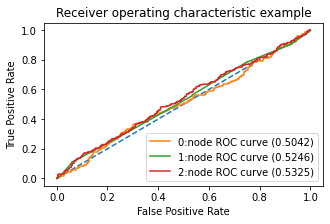

In [430]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], linestyle='--')
for key in tqdm(y_predict_proba_dic.keys(), ncols=20):
    y_scores = [y_predict_proba_1[1] for y_predict_proba_1 in y_predict_proba_dic[key]]
    fpr, tpr, _  =  roc_curve(y_binary_test, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=str(key) + ':node ROC curve (%0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

100%|█| 3/3 [00:00<0


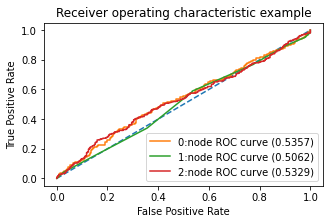

In [442]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], linestyle='--')
for key in tqdm(y_predict_proba_dic.keys(), ncols=20):
    y_scores = [y_predict_proba_1[1] for y_predict_proba_1 in y_predict_proba_dic[key]]
    fpr, tpr, _  =  roc_curve(y_binary_test, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=str(key) + ':node ROC curve (%0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

100%|█| 3/3 [00:00<0


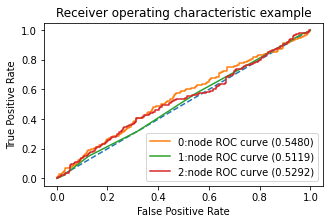

In [496]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], linestyle='--')
for key in tqdm(y_predict_proba_dic.keys(), ncols=20):
    y_scores = [y_predict_proba_1[1] for y_predict_proba_1 in y_predict_proba_dic[key]]
    fpr, tpr, _  =  roc_curve(y_binary_test, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=str(key) + ':node ROC curve (%0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 神经网络分类

In [47]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [58]:
def full_connect_network(n_cols):
    # Add an Input Layer
    input_layer = layers.Input((n_cols, ))
    
    Dense_layer_1 = layers.Dense(240, activation="relu")(input_layer)
    Dense_layer_2 = layers.Dense(120, activation="relu")(Dense_layer_1)
    Dense_layer_3 = layers.Dropout(0.3)(Dense_layer_2)
    Dense_layer_4 = layers.Dense(2, activation='softmax')(Dense_layer_3)
    
    model = models.Model(inputs=input_layer, outputs=Dense_layer_4)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])    
    # model.summary()
    
    return model

In [49]:
# 提前停止监视器设置为3，这意味着在连续3次运行后，模型的性能没有改进的话，训练将会被停止
my_callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=5)]

In [64]:
history_list = []
model_list = []

for i in tqdm(range(5), ncols=70):
    model = full_connect_network(x_abs_train.shape[1])
    history = model.fit(x_abs_train, y_category_train, 
                        validation_data=(x_abs_valid, y_category_valid), 
                        verbose=0, epochs=100, batch_size=256, shuffle=False,
                        callbacks=my_callbacks)
    history_list.append(history)
    model_list.append(model)

100%|███████████████████████████████████| 5/5 [00:15<00:00,  3.18s/it]


In [65]:
metrics_list = []
roc_list = []

for model in tqdm(model_list, ncols=70):
    y_pred = model.predict(x_abs_test, batch_size=256, verbose=0)
    y_pred_proba = np.array(y_pred, dtype=float)
    y_pred_proba = y_pred_proba[:,1]
    fpr, tpr, _  =  roc_curve(y_binary_test, list(y_pred_proba))
    roc_list.append(auc(fpr,tpr))

    for i in range(len(y_pred)):
        max_value=max(y_pred[i])
        for j in range(len(y_pred[i])):
            if max_value==y_pred[i][j]:
                y_pred[i][j]=1
            else:
                y_pred[i][j]=0
    report = classification_report(y_category_test, y_pred, digits=4)
    p = re.compile('  |\n', re.S)
    report = p.sub(' ', report)
    metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
    metrics_list.append(metrics_content)

100%|███████████████████████████████████| 5/5 [00:01<00:00,  2.87it/s]


## abstract

In [66]:
# abstract
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))

NN acc:  0.6510
NN macro:  0.4094
NN weighted:  0.5304
[0.6486, 0.6384, 0.6551, 0.6538, 0.6589]
[0.407, 0.424, 0.4162, 0.3953, 0.4043]
[0.5283, 0.5366, 0.5359, 0.522, 0.5291]
NN roc:  0.4930


In [67]:
print(classification_report(y_category_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.4000    0.0076    0.0149       264
           1     0.6606    0.9942    0.7938       513

   micro avg     0.6589    0.6589    0.6589       777
   macro avg     0.5303    0.5009    0.4043       777
weighted avg     0.5721    0.6589    0.5291       777
 samples avg     0.6589    0.6589    0.6589       777



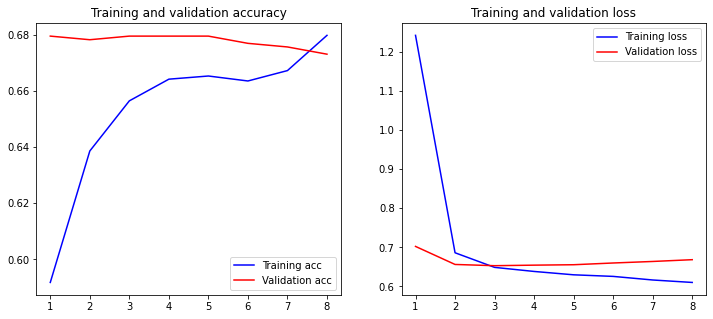

In [68]:
plot_history(history_list[0])